# import funcs and load hydrographics profiles ds

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 40
mpl.rcParams["axes.titlesize"] = 40
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["font.size"] = 20
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

path = '/home/theospira/notebooks/projects/WW_climatology'

# seasonal gridding

In [2]:
def median_gridding_szn(dsvar):
    
    if 'pres' in dsvar.dims:
        arr = np.ndarray([4,360,40,ds.pres.size])*np.nan
    else:
        arr = np.ndarray([4,360,40])*np.nan
    
    # define lon min and max resp
    gs = 1
    lon_min = -180
    lon_max = 180
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = range(0,lon_max-lon_min,gs)
    
    lat_min = -80
    lat_max = -40
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = range(0,lat_max-lat_min,gs)
    
    # group by seasons
    var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4))
    
    # group into lon bins
    for t,gr_t in tqdm(var):
        var1 = gr_t.groupby_bins('lon',lon,labels=lon_labels,restore_coord_dims=True)
        
        # now group into lat bins for each lon group:
        for ln,gr_ln in var1:
            var2 = gr_ln.groupby_bins('lat',lat,labels=lat_labels,restore_coord_dims=True)
            
            # now take the mode!
            for lt,gr_lt in var2:
                arr[t,ln,lt] = gr_lt.median('n_prof',skipna=True)
            
    return arr

In [3]:
from scipy.stats import mode

def mode_gridding_szn(dsvar):
    
    if 'pres' in dsvar.dims:
        arr = np.ndarray([4,360,40,ds.pres.size])*np.nan
    else:
        arr = np.ndarray([4,360,40])*np.nan
    
    # define lon min and max resp
    gs = 1
    lon_min = -180
    lon_max = 180
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = range(0,lon_max-lon_min,gs)
    
    lat_min = -80
    lat_max = -40
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = range(0,lat_max-lat_min,gs)
    
    # group by seasons
    var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4))
    
    # group into lon bins
    for t,gr_t in tqdm(var):
        var1 = gr_t.groupby_bins('lon',lon,labels=lon_labels,restore_coord_dims=True)
        
        # now group into lat bins for each lon group:
        for ln,gr_ln in var1:
            var2 = gr_ln.groupby_bins('lat',lat,labels=lat_labels,restore_coord_dims=True)
            
            # now take the mode!
            for lt,gr_lt in var2:
                arr[t,ln,lt] = mode(gr_lt,nan_policy='omit')[0]
            
    return arr

In [4]:
from scipy.stats import mode

def count_gridding_szn(dsvar):
    
    arr = np.ndarray([4,360,40])*np.nan
    
    # define lon min and max resp
    gs = 1
    lon_min = -180
    lon_max = 180
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = range(0,lon_max-lon_min,gs)
    
    lat_min = -80
    lat_max = -40
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = range(0,lat_max-lat_min,gs)
    
    # group by seasons
    var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4))
    
    # group into lon bins
    for t,gr_t in tqdm(var):
        var1 = gr_t.groupby_bins('lon',lon,labels=lon_labels,restore_coord_dims=True)
        
        # now group into lat bins for each lon group:
        for ln,gr_ln in var1:
            var2 = gr_ln.groupby_bins('lat',lat,labels=lat_labels,restore_coord_dims=True)
            
            # now take the mode!
            for lt,gr_lt in var2:
                arr[t,ln,lt] = gr_lt.count()
            
    return arr

In [5]:
def mean_gridding(dsvar):
    """
    annual median on 1°x1° grid
    """
    if 'pres' in dsvar.dims:
        arr = np.ndarray([4,360,40,ds.pres.size])*np.nan
    else:
        arr = np.ndarray([4,360,40])*np.nan
    
    # define lon min and max resp
    gs = 1
    lon_min = -180
    lon_max = 180
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = range(0,lon_max-lon_min,gs)
    
    lat_min = -80
    lat_max = -40
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = range(0,lat_max-lat_min,gs)
    
    # group into lon bins
    var1 = dsvar.groupby_bins('lon',lon,labels=lon_labels,restore_coord_dims=True)
    
    # now group into lat bins for each lon group:
    for ln,gr_ln in var1:
        var2 = gr_ln.groupby_bins('lat',lat,labels=lat_labels,restore_coord_dims=True)
        
        # now take the mode!
        for lt,gr_lt in var2:
            arr[t,ln,lt] = gr_lt.median('n_prof',skipna=True)
        
    return arr

In [6]:
def std_gridding(dsvar):
    """
    annual standard deviation on 1°x1° grid
    """
    
    if 'pres' in dsvar.dims:
        arr = np.ndarray([4,360,40,ds.pres.size])*np.nan
    else:
        arr = np.ndarray([4,360,40])*np.nan
    
    # define lon min and max resp
    gs = 1
    lon_min = -180
    lon_max = 180
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = range(0,lon_max-lon_min,gs)
    
    lat_min = -80
    lat_max = -40
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = range(0,lat_max-lat_min,gs)
    
    # group into lon bins
    var1 = dsvar.groupby_bins('lon',lon,labels=lon_labels,restore_coord_dims=True)
    
    # now group into lat bins for each lon group:
    for ln,gr_ln in var1:
        var2 = gr_ln.groupby_bins('lat',lat,labels=lat_labels,restore_coord_dims=True)
        
        # now take the mode!
        for lt,gr_lt in var2:
            arr[t,ln,lt] = gr_lt.std('n_prof',skipna=True)
        
    return arr

# load ds and grid

In [10]:
ds = xr.open_dataset(path+'/data/hydrographic_profiles/superseded/ww_gauss_smoothed_ds-preDec23.nc')

In [12]:
ds.ww_ct.notnull().sum()

<xarray.DataArray 'ww_ct' ()>
array(266856)

In [7]:
ds = xr.open_dataset(path+'/data/hydrographic_profiles/ww_gauss_smoothed_ds.nc')

for i,d in enumerate(np.unique(ds.dsource)):
    idx = np.where(ds.dsource == d)[0]
    ds['dsource'][idx] = i+1

ds.dsource.attrs['description'] = "'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"
ds['dsource'] = ds['dsource'].astype(int)

## conver from pres to z

In [9]:
mld = np.ndarray(ds.mlp.shape)*np.nan
ub  = np.ndarray(ds.up_bd.shape)*np.nan
lb  = np.ndarray(ds.lw_bd.shape)*np.nan
cd  = np.ndarray(ds.ww_cp.shape)*np.nan

# find indeces of profiles containing WW
idx = np.where(ds.ww_type.notnull())[0]
tmp = ds.isel(n_prof=idx)

#
mlp = ds.mlp.data
cp  = tmp.ww_cp.data
ubp = tmp.up_bd.data
lbp = tmp.lw_bd.data
lt  = tmp.lat.data

mld     = gsw.z_from_p(mlp,ds.lat.data)
cd[idx] = gsw.z_from_p(cp,lt)
ub[idx] = gsw.z_from_p(ubp,lt)
lb[idx] = gsw.z_from_p(lbp,lt)

thcc = lb - ub

In [10]:
# add depth variables to dataset
ds['mld']   = xr.DataArray(mld,
                           dims   = {'n_prof':ds.n_prof.data},
                           coords = {'n_prof':ds.n_prof.data},
                            )
ds['ww_cd'] = xr.DataArray(cd,
                           dims   = {'n_prof':ds.n_prof.data},
                           coords = {'n_prof':ds.n_prof.data},
                            )
ds['up_bd'] = xr.DataArray(ub,
                           dims   = {'n_prof':ds.n_prof.data},
                           coords = {'n_prof':ds.n_prof.data},
                            )
ds['lw_bd'] = xr.DataArray(lb,
                           dims   = {'n_prof':ds.n_prof.data},
                           coords = {'n_prof':ds.n_prof.data},
                            )
ds['thcc']  = xr.DataArray(thcc,
                           dims   = {'n_prof':ds.n_prof.data},
                           coords = {'n_prof':ds.n_prof.data},
                            )

In [11]:
ds_ww = ds.isel(n_prof=np.where(ds.ww_type.notnull())[0]).copy()

clim = 'season'

dvars_4 = [] # 4D vars
for i in tqdm(['asal', 'ctemp', 'rho','sig','n2',],"vars"):
    dvars_4 += median_gridding_szn(ds[i]),

ww_vars = ['up_bd','ww_cd','ww_ct','ww_sa','lw_bd','thcc','ww_n2','sig_c']

dvars_3 = [] # 3D vars

dvars_3 += median_gridding_szn(ds['mld'],),
for i in tqdm(ww_vars,"vars"):
    dvars_3 += median_gridding_szn(ds_ww[i],),

n_prof  = count_gridding_szn(ds['n_prof'],)
ww_prof = count_gridding_szn(ds_ww['n_prof'],)
dsource = mode_gridding_szn(ds['dsource'])
ww_type = mode_gridding_szn(ds_ww['ww_type'])

vars:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

vars:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
ds_ww = ds.isel(n_prof=np.where(ds.ww_type.notnull())[0]).copy()

# run gridding through other vars
dvars_3 = [] # 3D vars
dvars_3 += median_gridding_szn(ds['mld'],),
for i in tqdm(ww_vars,"vars"):
    dvars_3 += median_gridding_szn(ds_ww[i],),

n_prof  = count_gridding_szn(ds['n_prof'],)
ww_prof = count_gridding_szn(ds_ww['n_prof'],)
dsource = mode_gridding_szn(ds['dsource'])
ww_type = mode_gridding_szn(ds_ww['ww_type'])

  0%|          | 0/4 [00:00<?, ?it/s]

vars:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
ds

<xarray.Dataset>
Dimensions:  (n_prof: 592946, pres: 196)
Coordinates:
  * n_prof   (n_prof) int64 0 1 2 3 4 5 ... 620288 620289 620290 620291 620292
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 -57.46 -69.32 -58.43 ... -41.05 -42.42 -65.83
    time     (n_prof) datetime64[ns] 2004-01-01T10:01:28.999999744 ... 2021-1...
Data variables: (12/21)
    temp     (n_prof, pres) float64 ...
    psal     (n_prof, pres) float64 ...
    dsource  (n_prof) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    mld      (n_prof) float64 -11.89 -33.65 -9.907 ... -53.57 -21.83 -9.901
    asal     (n_prof, pres) float32 ...
    ctemp    (n_prof, pres) float32 ...
    ...       ...
    lw_bd    (n_prof) float64 -116.9 -162.3 -122.8 nan ... -95.06 nan nan -132.6
    ww_type  (n_prof) float64 2.0 2.0 2.0 nan 2.0 2.0 ... nan 2.0 nan nan 2.0
    thcc     (n_prof) float64 -105.0 -128.6 -112.9 nan ... -67.33 nan nan -122.7
    ww_n2    (n_prof) float64 ...
    ww_msk   (n_prof, pres) float64 ...
    ww_cd    (n_prof) float64 -89.15 -89.07 -71.32 nan ... -75.26 nan nan -43.56
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

In [12]:
ww_msk = median_gridding_szn(ds_ww['ww_msk'])

  0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
# create dataset
x    = 1 # grid size
time = np.arange(0,4,1) # JFM,AMJ,JAS,OND: summer,...,spring
p    = ds.pres.data
lat  = np.arange(-79,-40+x,x)
lon  = np.arange(-180,180,x)

ds_grid = xr.Dataset(
            data_vars = dict(
                            ctemp   = (['time','lon','lat','pres'], dvars_4[1]),
                            asal    = (['time','lon','lat','pres'], dvars_4[0]),
                            rho     = (['time','lon','lat','pres'], dvars_4[2]),
                            sig     = (['time','lon','lat','pres'], dvars_4[3]),
                            n2      = (['time','lon','lat','pres'], dvars_4[4]),
                            mld     = (['time', 'lon','lat'], dvars_3[0]),
                            up_bd   = (['time', 'lon','lat'], dvars_3[1]),
                            lw_bd   = (['time', 'lon','lat'], dvars_3[5]),
                            ww_cd   = (['time', 'lon','lat'], dvars_3[2]),
                            ww_ct   = (['time', 'lon','lat'], dvars_3[3]),
                            ww_sa   = (['time', 'lon','lat'], dvars_3[4]),
                            thcc    = (['time', 'lon','lat'], dvars_3[6]),
                            ww_n2   = (['time', 'lon','lat'], dvars_3[7]),
                            sig_c   = (['time', 'lon','lat'], dvars_3[8]),
                            ww_type = (['time', 'lon','lat'], ww_type),
                            dsource = (['time', 'lon','lat'], dsource),
                            n_prof  = (['time', 'lon','lat'], n_prof),
                            ww_prof = (['time', 'lon','lat'], ww_prof),
                            ww_msk  = (['time','lon','lat','pres'], ww_msk),
                
                            ),
            coords   = dict(
                            time    = (['time'], time),
                            lon     = (['lon'],  lon),
                            lat     = (['lat'],  lat),
                            pres    = (['pres'], p)
                            ),
            attrs    = dict(description=str(
    f"1 degree grid of median climatology ({clim}) along 2dbar pressure interpolated and quality controlled Argo, MEOP, SOCCOM, CTDs, and Gliders data from 2004 to 2021. Contains good QC and Wilson et al (2019) QC. Smoothed temp and psal using Gauss smoothing with stand dev=2. Gsw funcs and WW subsequently calculated. Further QC post calculation: NaN any WW vars profiles with a lower boundary deeper than 300dbar; drop any profiles with fewer than 10 datapoints. Removed vertical profiles by cross referencing temperature profile with mixed layer temperature. If there is not a significant change from the mean ML temperature, we remove the profile (a change of 0.25°C or more for at least 5% of the profile)."))
            )

# sort some stuff
ds_grid.n_prof.attrs['description']  = 'total number of profiles across the time span for that month.'
ds_grid.ww_prof.attrs['description'] = 'total number of profiles across the time span for that month containing Winter Water.'
ds_grid.ww_type.attrs['description'] = 'mode of ww classification per grid cell. key: 1:ML WW, 2:Subsurface WW'
ds_grid.dsource.attrs['description'] = "mode of data source. key: 'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"
ds_grid.ww_msk.attrs['description']  = 'masking where there exists WW in the water column per grid cell (median). 1 => there exists WW.'

# reorder seasons
ds_grid['time'] = [2,3,0,1]
ds_grid = ds_grid.sortby('time')
ds_grid.time.attrs['description'] = '0:Winter, 1:Spring, 2:Summer, 3:Autumn'

In [14]:
# save that mf dataset
ds_grid.to_netcdf('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/SO_1yr_clim_seasonal.nc')

# seasonal gridding of statistic - std?

In [ ]:
clim = 'season'

dvars_4 = [] # 4D vars
for i in tqdm(['asal', 'ctemp', 'rho']):
    dvars_4 += grid_var_4d(ds[i],clim),

ww_vars = ['mlp','up_bd','ww_cp','ww_ct','ww_sa','lw_bd','thcc','ww_n2']

dvars_3 = [] # 3D vars
for i in tqdm(ww_vars):
    dvars_3 += grid_var_3d(ds_ww[i],clim),
ww_type = grid_var_3d_mode(ds_ww['ww_type'],clim,)
n_prof  = grid_var_3d_sum(ds,'n_prof',clim,)
ww_prof = grid_var_3d_sum(ds_ww,'n_prof',clim,)

In [ ]:
x    = 1 
time = np.arange(0,4,1) # JFM,AMJ,JAS,OND: summer,...,spring
p    = ds.pres.data
lat  = np.arange(-79,-40+x,x)
lon  = np.arange(-180,180,x)

ds_grid = xr.Dataset(
            data_vars = dict(
                            ctemp   = (['time','pres','lon','lat'], dvars_4[1].data),
                            asal    = (['time','pres','lon','lat'], dvars_4[0].data),
                            rho     = (['time','pres','lon','lat'], dvars_4[2].data),
                            mlp     = (['time', 'lon','lat'], dvars_3[0].data),
                            up_bd   = (['time', 'lon','lat'], dvars_3[1].data),
                            lw_bd   = (['time', 'lon','lat'], dvars_3[5].data),
                            ww_cp   = (['time', 'lon','lat'], dvars_3[2].data),
                            ww_ct   = (['time', 'lon','lat'], dvars_3[3].data),
                            ww_sa   = (['time', 'lon','lat'], dvars_3[4].data),
                            thcc    = (['time', 'lon','lat'], dvars_3[6].data),
                            ww_n2   = (['time', 'lon','lat'], dvars_3[7].data),
                            ww_type = (['time', 'lon','lat'], ww_type.data),
                            n_prof  = (['time', 'lon','lat'], n_prof.data),
                            ww_prof = (['time', 'lon','lat'], ww_prof.data),                
                            ),
            coords   = dict(
                            time    = (['time'], time),
                            lon     = (['lon'], lon),
                            lat     = (['lat'], lat),
                            pres    = (['pres'], p)
                            ),
            attrs    = dict(description=str(
    f"1 degree grid of median climatology ({clim}) along 2dbar pressure interpolated and quality controlled Argo, MEOP, SOCCOM, CTDs, and Gliders data from 2004 to 2021. Contains good QC and Wilson et al (2019) QC. Smoothed temp and psal using Gauss smoothing with stand dev=2. Gsw funcs and WW subsequently calculated. Further QC post calculation: NaN any WW vars profiles with a lower boundary deeper than 300dbar; drop any profiles with fewer than 10 datapoints. Removed vertical profiles by cross referencing temperature profile with mixed layer temperature. If there is not a significant change from the mean ML temperature, we remove the profile (a change of 0.25°C or more for at least 5% of the profile)."))
            )

ds_grid.n_prof.attrs['description']  = 'total number of profiles across the time span for that month.'
ds_grid.ww_prof.attrs['description'] = 'total number of profiles across the time span for that month containing Winter Water.'
ds_grid.ww_type.attrs['description'] = 'mode of ww type per grid cell'                            

In [ ]:
ds_grid['time'] = [2,3,0,1]
ds_grid = ds_grid.sortby('time')
ds_grid.time.attrs['description'] = '0:Winter, 1:Spring, 2:Summer, 3:Autumn'

In [23]:
ds_grid.to_netcdf('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/SO_1yr_clim_seasonal.nc')

# annual gridding by mode

In [5]:
ds = xr.open_dataset('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/ww_gauss_smoothed_ds.nc')

for i,d in enumerate(np.unique(ds.dsource)):
    idx = np.where(ds.dsource == d)[0]
    ds['dsource'][idx] = i+1

ds.dsource.attrs['description'] = "'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"
ds['dsource'] = ds['dsource'].astype(int)

In [10]:
from scipy.stats import mode

def mode_gridding_yr(dsvar):
    
    if 'pres' in dsvar.dims:
        arr = np.ndarray([360,40,ds.pres.size])*np.nan
    else:
        arr = np.ndarray([360,40])*np.nan
    
    # define lon min and max resp
    gs = 1
    lon_min = -180
    lon_max = 180
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = range(0,lon_max-lon_min,gs)
    
    lat_min = -80
    lat_max = -40
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = range(0,lat_max-lat_min,gs)
    
    
    var1 = dsvar.groupby_bins('lon',lon,labels=lon_labels,restore_coord_dims=True)
    
    # now group into lat bins for each lon group:
    for ln,gr_ln in var1:
        var2 = gr_ln.groupby_bins('lat',lat,labels=lat_labels,restore_coord_dims=True)
        
        # now take the mode!
        for lt,gr_lt in var2:
            arr[ln,lt] = mode(gr_lt,nan_policy='omit')[0]
        
    return arr

In [16]:
arr = mode_gridding_yr(ds.ww_type)
dsr = mode_gridding_yr(ds.dsource)

In [17]:
x    = 1 
lat  = np.arange(-79,-40+x,x)
lon  = np.arange(-180,180,x)

ds_grid = xr.Dataset(
            data_vars = dict(
                            dsource = (['lon','lat'], dsr),
                            ww_type = (['lon','lat'], arr),
                            ),
            coords   = dict(
                            lon     = (['lon'], lon),
                            lat     = (['lat'], lat),
                            ),
            attrs    = dict(description=str(
    f"annual mode."))
            )

ds_grid.dsource.attrs['description'] = "'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"
ds_grid.ww_type.attrs['description'] = "1:ML WW, 2:Subsurface WW"

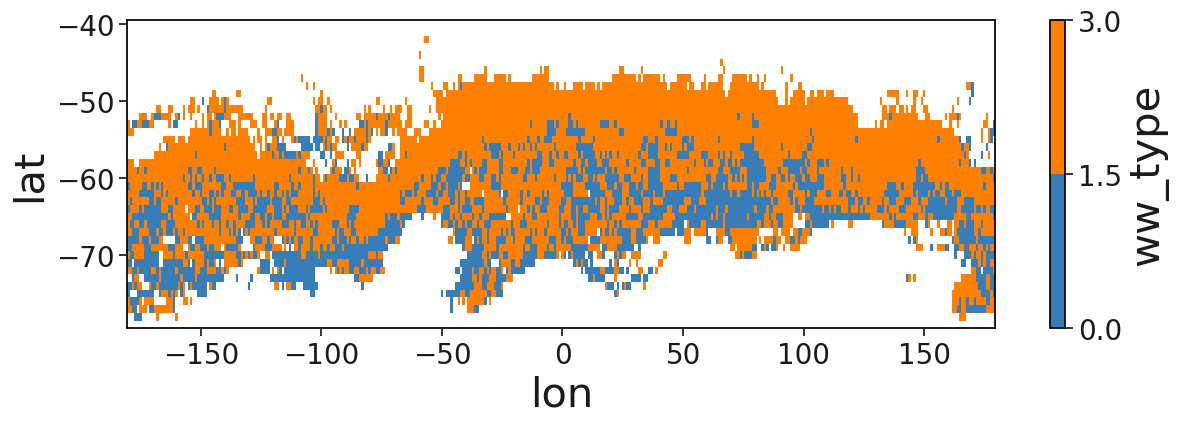

In [23]:
cm = mpl.colors.LinearSegmentedColormap.from_list("", ['#377eb8','#ff7f00']) # blue and orange, resp


ds_grid.ww_type.plot(x='lon',cmap=cm,vmin=0,vmax=3,levels=3,add_colorbar=True, figsize=(14,4))

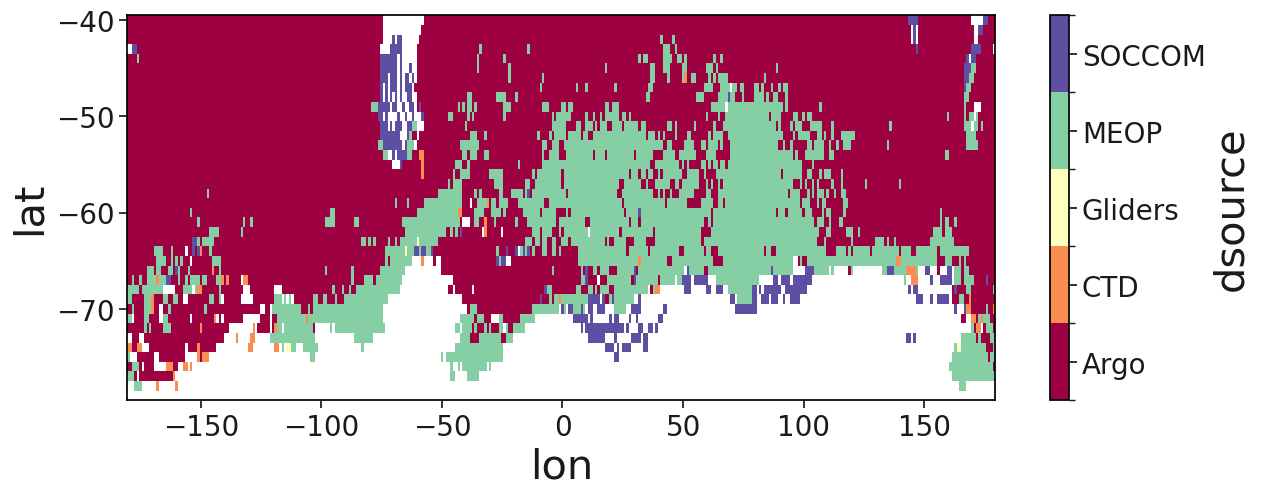

In [36]:
ax = ds_grid.dsource.plot(x='lon',cmap='Spectral',vmin=1,vmax=6,levels=6,add_colorbar=True, figsize=(14,5))
cb = ax.colorbar
cb.set_ticks(np.arange(1.5,6,1),)
cb.set_ticklabels(['Argo', 'CTD', 'Gliders', 'MEOP', 'SOCCOM'])